This script will run the ak and canada models together

Read in packages

In [1]:
import pandas as pd
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.lib.io import file_io
from tensorflow.python.keras.optimizer_v2.adam import Adam
import os
import segmentation_models as sm
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Input, AvgPool2D
from tensorflow.keras.models import Model
from keras_unet_collection import models
import tensorflow_addons as tfa
import logging
# from tensorflow import tensorflow.keras.mixed_precision.set_global_policy("mixed_float16")

AttributeError: module 'keras.utils.generic_utils' has no attribute 'get_custom_objects'

Read in the testing data for all four models, plus all the mtbs data for models 1 and 2

In [2]:


#----------projected with negative nbac training 128
model_test = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_0_final_128_testing_files.csv')['Files'].tolist()



good_ids= pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/raw_files/ak_ca_1985_clip.csv')

def get_good(in_list, good_frame):
    
    final = []
    for i in in_list:

        try:

            in_id = int(i.split('/')[-1].split('_')[2].replace('.npy', ''))

            if in_id in good_frame['ID']:

                final.append(i)
        except:
            pass
        
    return final


model_test = get_good(model_test, good_ids)

#mtbs files to test on 
land_sent_mtbs_128_train = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_mtbs_0_128_training_files.csv')['Files'].tolist()
land_sent_mtbs_128_val = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_mtbs_0_128_validation_files.csv')['Files'].tolist()
land_sent_mtbs_128_test = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_proj_mtbs_0_128_testing_files.csv')['Files'].tolist()


mtbs = land_sent_mtbs_128_train + land_sent_mtbs_128_val + land_sent_mtbs_128_test

#function to get files from storage bucket
def get_files(bucket_path):

    """argument is the path to where the numpy
    save files are located, return a list of filenames
    """
    all = []

    #list of files
    files = os.listdir(bucket_path)

    #get list of filenames we will use, notte I remove images that don't have a target due to clouds
    file_names = []
    for f in files:
        
        if f.endswith('.npy'):

            all.append(os.path.join(bucket_path, f))
        
    return(all)
  





Set up image generator for dnbr


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

min_max = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)
min_max = min_max[['6']]

class img_gen(tensorflow.keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays).
    Inputs are batch size, the image size, the input paths (x) and target paths (y)
    """

    #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
    def __init__(self, batch_size, img_size, input_img_paths):
	    self.batch_size = batch_size
	    self.img_size = img_size
	    self.input_img_paths = input_img_paths
	    self.target_img_paths = input_img_paths

    #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
    def __len__(self):
	    return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
		
        x = np.zeros((self.batch_size,) + self.img_size, dtype="float32") #create matrix of zeros which will have the dimension (batch_size, height, wideth, n_bands), 8 is the n_bands
        
  
        #start populating x by enumerating over the input img paths
        for j, path in enumerate(batch_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, 6]

            # img = img * 1000
            img = img.astype(float)
            img = np.round(img, 3)
            img[img == 0] = -999

            img[np.isnan(img)] = -999


            img[img == -999] = np.nan

            in_shape = img.shape

            #turn to dataframe to normalize
            img = img.reshape(img.shape[0] * img.shape[1])

            img = pd.DataFrame(img)

            img.columns = min_max.columns

            img = pd.concat([min_max, img]).reset_index(drop = True)


            #normalize 0 to 1
            img = pd.DataFrame(scaler.fit_transform(img))

            img = img.iloc[2:]
#
#             img = img.values.reshape(in_shape)
            img = img.values.reshape(in_shape)

#             replace nan with -1
            img[np.isnan(img)] = -1

#apply standardization
# img = normalize(img, axis=(0,1))

            img = np.round(img, 3)
            #populate x
            x[j] = img#[:, :, 4:] index number is not included, 


        #do tthe same thing for y
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, -1]

            img = img.astype(int)

            img[img < 0] = 0
            img[img >1] = 0
            img[~np.isin(img, [0,1])] = 0

            img[np.isnan(img)] = 0
            img = img.astype(int)

            # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
            # y[j] = np.expand_dims(img, 2) 
            y[j] = img
  
       
    #Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    # y[j] -= 1

        return x, y

Image generator for 3 bands

In [4]:
min_max_vi = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)
min_max_vi = min_max_vi[['6', '7', '8']]

class img_gen_vi(tensorflow.keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays).
    Inputs are batch size, the image size, the input paths (x) and target paths (y)
    """

    #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
    def __init__(self, batch_size, img_size, input_img_paths):
	    self.batch_size = batch_size
	    self.img_size = img_size
	    self.input_img_paths = input_img_paths
	    self.target_img_paths = input_img_paths

    #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
    def __len__(self):
	    return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
		
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") #create matrix of zeros which will have the dimension height, wideth, n_bands), 8 is the n_bands
        
  
         #start populating x by enumerating over the input img paths
        for j, path in enumerate(batch_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, 6:9]

            # img = img * 1000
            img = img.astype(float)
            img = np.round(img, 3)
            img[img == 0] = -999

            img[np.isnan(img)] = -999


            img[img == -999] = np.nan

            in_shape = img.shape
            
            #turn to dataframe to normalize
            img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
			
            img = pd.DataFrame(img)
			
            img.columns = min_max_vi.columns
			
            img = pd.concat([min_max_vi, img]).reset_index(drop = True)


            #normalize 0 to 1
            img = pd.DataFrame(scaler.fit_transform(img))
			
            img = img.iloc[2:]
#
#             img = img.values.reshape(in_shape)
            img = img.values.reshape(in_shape)

#             replace nan with -1
            img[np.isnan(img)] = -1

#apply standardization
# img = normalize(img, axis=(0,1))

            img = np.round(img, 3)
            #populate x
            x[j] = img#[:, :, 4:] index number is not included, 


        #do tthe same thing for y
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, -1]

            img = img.astype(int)

            img[img < 0] = 0
            img[img >1] = 0
            img[~np.isin(img, [0,1])] = 0

            img[np.isnan(img)] = 0
            img = img.astype(int)

            # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
            # y[j] = np.expand_dims(img, 2) 
            y[j] = img
  
       
    #Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    # y[j] -= 1

        return x, y


Read in the images based on the generator

In [5]:
#batch size and img size
BATCH_SIZE = 15
GPUS = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
strategy = tensorflow.distribute.MirroredStrategy() #can add GPUS here to select specific ones
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

batch_size = BATCH_SIZE * strategy.num_replicas_in_sync

#image size
img_size = (128, 128)

#number of classes to predict
num_classes = 1

#nbac testing dnbr
models_dnbr_gen =  img_gen(batch_size, img_size, model_test)
models_vi_gen =  img_gen_vi(batch_size, img_size, model_test)

#mtbs
mtbs_dnbr_gen =  img_gen(batch_size, img_size, mtbs)
mtbs_vi_gen =  img_gen_vi(batch_size, img_size, mtbs)



Number of devices: 4


Read in all the models

In [6]:
# #-------landsat 8
# model_1 = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/l8_collection2_dnbr_one_128_2d_ds_proj_gids.tf", 
#                                            custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
#                                                            'recall':sm.metrics.Recall(threshold = 0.5),
#                                                             'f1-score': sm.metrics.FScore(threshold=0.5),
#                                                              'iou_score': sm.metrics.IOUScore(threshold=0.5),
#                                                               'accuracy': 'accuracy'})

# model_2 = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/l8_collection2_VI_one_128_2d_ds_proj_final_gids.tf", 
#                                            custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
#                                                            'recall':sm.metrics.Recall(threshold = 0.5),
#                                                             'f1-score': sm.metrics.FScore(threshold=0.5),
#                                                              'iou_score': sm.metrics.IOUScore(threshold=0.5)})

# model_3 = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/l8_collection2_dnbr_one_128_2d_ds_proj_mtbs_gids.tf", 
#                                            custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
#                                                            'recall':sm.metrics.Recall(threshold = 0.5),
#                                                             'f1-score': sm.metrics.FScore(threshold=0.5),
#                                                              'iou_score': sm.metrics.IOUScore(threshold=0.5)})

model_4 = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/l8_collection2_VI_one_128_2d_ds_proj_final_mtbs_gids.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})




Model 1 testing scores

In [7]:
model_1_res = model_1.evaluate_generator(mtbs_dnbr_gen, 100)

iou = model_1_res[-2]
precision = model_1_res[-5]
recall = model_1_res[-4]
f1 = model_1_res[-3]
accuracy = model_1_res[-1]

print(f"Model 1 testing IoU is {iou}")
print(f"Model 1 testing precision is {precision}")
print(f"Model 1 testing recall is {recall}")
print(f"Model 1 testing f1 is {f1}")
print(f"Model 1 testing accuracy is {accuracy}")


/tmp/ipykernel_762106/3175516196.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_1_res = model_1.evaluate_generator(mtbs_dnbr_gen, 100)


Model 1 testing IoU is 0.790679931640625
Model 1 testing precision is 0.9726361036300659
Model 1 testing recall is 0.8082199096679688
Model 1 testing f1 is 0.8809217810630798
Model 1 testing accuracy is 0.963837742805481


Model 2 testing scores

In [11]:
model_2_res = model_2.evaluate_generator(mtbs_vi_gen, 100)

iou = model_2_res[-2]
precision = model_2_res[-5]
recall = model_2_res[-4]
f1 = model_2_res[-3]
accuracy = model_2_res[-1]

print(f"Model 2 testing IoU is {iou}")
print(f"Model 2 testing precision is {precision}")
print(f"Model 2 testing recall is {recall}")
print(f"Model 2 testing f1 is {f1}")
print(f"Model 2 testing accuracy is {accuracy}")

/tmp/ipykernel_762106/455516871.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_2_res = model_2.evaluate_generator(mtbs_vi_gen, 100)


Model 2 testing IoU is 0.8228231072425842
Model 2 testing precision is 0.9722893238067627
Model 2 testing recall is 0.8424709439277649
Model 2 testing f1 is 0.9010870456695557
Model 2 testing accuracy is 0.9692376255989075


Model 3 testing scores

In [9]:
model_3_res = model_3.evaluate_generator(models_dnbr_gen, 100)

iou = model_3_res[-2]
precision = model_3_res[-5]
recall = model_3_res[-4]
f1 = model_3_res[-3]
accuracy = model_3_res[-1]

print(f"Model 2 testing IoU is {iou}")
print(f"Model 2 testing precision is {precision}")
print(f"Model 2 testing recall is {recall}")
print(f"Model 2 testing f1 is {f1}")
print(f"Model 2 testing accuracy is {accuracy}")

/tmp/ipykernel_762106/1577085814.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_3_res = model_3.evaluate_generator(models_dnbr_gen, 100)


Model 2 testing IoU is 0.865113377571106
Model 2 testing precision is 0.920407235622406
Model 2 testing recall is 0.9351356029510498
Model 2 testing f1 is 0.9272314310073853
Model 2 testing accuracy is 0.9808530211448669


Model 4 testing scores

In [7]:
model_4_res = model_4.evaluate_generator(models_vi_gen, 100)

iou = model_4_res[-2]
precision = model_4_res[-5]
recall = model_4_res[-4]
f1 = model_4_res[-3]
accuracy = model_4_res[-1]

print(f"Model 2 testing IoU is {iou}")
print(f"Model 2 testing precision is {precision}")
print(f"Model 2 testing recall is {recall}")
print(f"Model 2 testing f1 is {f1}")
print(f"Model 2 testing accuracy is {accuracy}")

/tmp/ipykernel_882445/111447473.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_4_res = model_4.evaluate_generator(models_vi_gen, 100)


Model 2 testing IoU is 0.8775147795677185
Model 2 testing precision is 0.938153088092804
Model 2 testing recall is 0.931460440158844
Model 2 testing f1 is 0.934390127658844
Model 2 testing accuracy is 0.9827530384063721


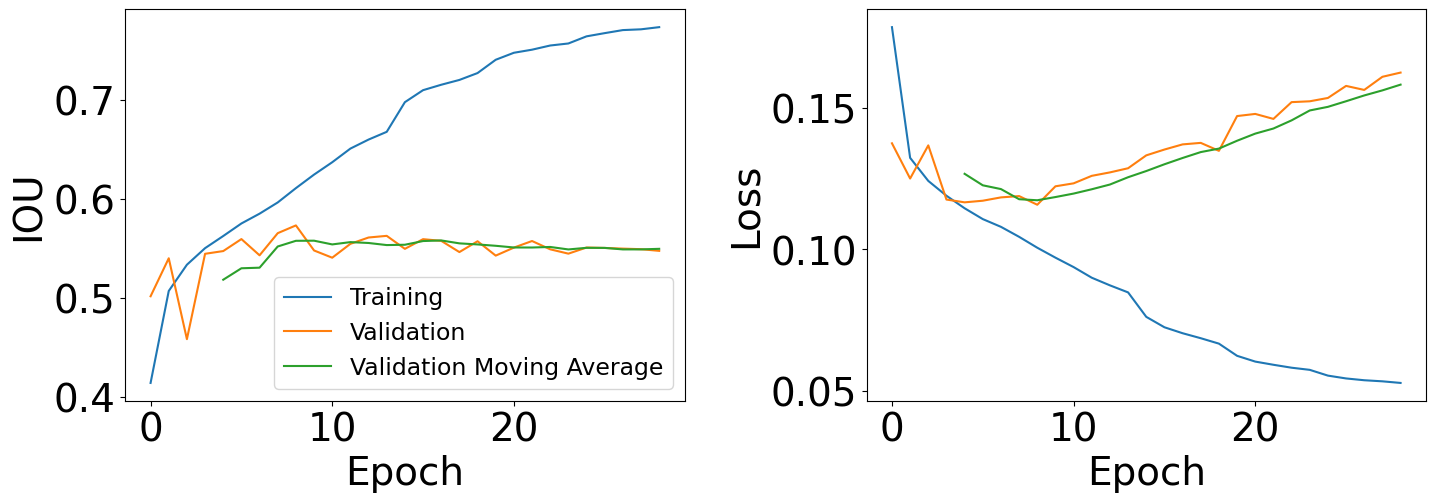

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os

font = {'family' : 'normal',
        'size'   : 28}

# df = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/modis_dnbr_0_five_plus_128_2d_ds_aug.csv")
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj.csv')

# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_final.csv')

#good models
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_VI_one_128_2d_ds_proj_final_mtbs.csv').head(48)
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_final.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_mtbs.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_VI_one_128_2d_ds_proj_final.csv')
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_swin_no_reg_glob_norm.csv')
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_no_regularize_50_global_norm.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_regularize_50_global_norm.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_regularize_50_global_norm_85.csv')
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_mtbs_modis_16_global_norm.csv')
df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/combined_modis_16_global_norm.csv')

df['Moving Average'] = df['Val_IOU'].rolling(5).mean()
df['Moving Average2'] = df['Val_Loss'].rolling(5).mean()

#good models

# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj_mtbs.csv')
# df = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_long_neg.csv')
#l8_sent_collection2_crop_dnbr_0_two_long_128.csv
#l8_sent_collection2_crop_dnbr_0_two_long_128_neg_aug.csv
matplotlib.rc('font', **font)

#plot the curves
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(df['IOU'])
plt.plot(df['Val_IOU'])
plt.plot(df['Moving Average'])

# plt.title("Model IoU")
plt.ylabel('IOU')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.xlim(40,70)
plt.legend(['Training', 'Validation', 'Validation Moving Average'], loc='lower right', prop={'size': 17})


# Plot training & validation loss values
plt.subplot(222)
plt.plot(df['Loss'])
plt.plot(df['Val_Loss'])
plt.plot(df['Moving Average2'])

# plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.text(0.01, 0.00, 'Epoch', ha='center')


# plt.subplot(223)
# plt.plot(df['F1'])
# plt.plot(df['Val_F1'])
# plt.title('Model F1')
# plt.ylabel('F1')
# plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.tight_layout()

out_path = "/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/figures"
if not os.path.isdir(out_path):
    os.makedirs(out_path)

# plt.savefig(os.path.join(out_path, 'mtbs_nbac_VI_curve_adaptive.png'), dpi = 200, bbox_inches = 'tight') #17 epochs

# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# plt.subplot(122)
# plt.plot(df['Loss'])
# plt.plot(df['Val_Loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [5]:
df['Val_IOU'].idxmax()

24

Make final table with all the metrics, note here we will use the best IoU for all four models than get the other stats

In [52]:
#model 1
mod1 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_final.csv')
mod2 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_VI_one_128_2d_ds_proj_final.csv')
mod3 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_dnbr_one_128_2d_ds_proj_mtbs.csv')
mod4 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_VI_one_128_2d_ds_proj_final_mtbs.csv')

t = mod4[mod4['Val_IOU'] == mod4['Val_IOU'].max()][['Val_IOU', 'Val_Precision', 'Val_Recall', 'Val_F1', 'Val_Accuracy']]
print(t)


     Val_IOU  Val_Precision  Val_Recall   Val_F1  Val_Accuracy
49  0.854954       0.914487    0.930018  0.91691      0.980829


In [66]:
t2 = mod4[mod4['Val_IOU'] == mod4['Val_IOU'].max()]
print(t2.shape)


(1, 13)


In [86]:
len(model1_dnbr_res)

19

In [83]:
model_1.history

keras.callbacks.History

In [7]:
%load_ext tensorboard

In [8]:
%tensorboard --logdir "/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/nbac_mtbs_no_regularize_50_global_norm_3p"